<a href="https://colab.research.google.com/github/amanim7md/Happy-Sad-ClassificationAiModel/blob/main/Copy_of_Detecting_Happy_and_Sad_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h5py

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sad-and-happy-face-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3105538%2F5348785%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T191229Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D77ed7fdbccd896e2bc4f32950969970b39e335d6a6b2e931d3cfe84ff3610336f1c9ee3a24bcacdbea8fd92c0f13df4d96233b2e85ae233ed7693c311614caf7f03bb8c32446189ef2d9e7ad7d089f318298a571806d6f3c99a740deb0ebee346455791fe6b166b8793d58651786ccf84e873100ae11890bed789cc628fe4163c9578723e56b827cf1f5464c042ac600661e6379c27fbc6f09c0a188dc6a895818ebf2bf446b5fde8e56157927fd8744b04c5117a3e14b632f75fa480a6c5ca1d0ddd17410e495a5ab9b943c7533ac6f138b46272b7aeb071a2da9df0542a029e05069eb7bb5ec2954453cf5a95f8ddd22241cdbb9e2d8c456b530a16ea78679'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 233086881 bytes downloaded
Downloaded and uncompressed: sad-and-happy-face-detection
Data source import complete.


In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib as mp
import cv2
import imghdr
import os
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data_dir = 'data'

<font color='#008080'><b>Image Extensions</b></font>

In [ ]:
image_exts = ['jpeg' , 'jpg' ,'bmp' , 'png']

In [ ]:
os.listdir('/kaggle/input/sad-and-happy-face-detection/data')

['happy', 'sad']

In [ ]:
data_dir = '/kaggle/input/sad-and-happy-face-detection/data'
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

<font color='#008080'><b>Creating Image Dataset</b></font>

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/sad-and-happy-face-detection/data')


Found 1988 files belonging to 2 classes.


<font color='#008080'><b>Creating Data Iterator</b></font>

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

<font color='#008080'><b>Displaying a Selection of Images</b></font>

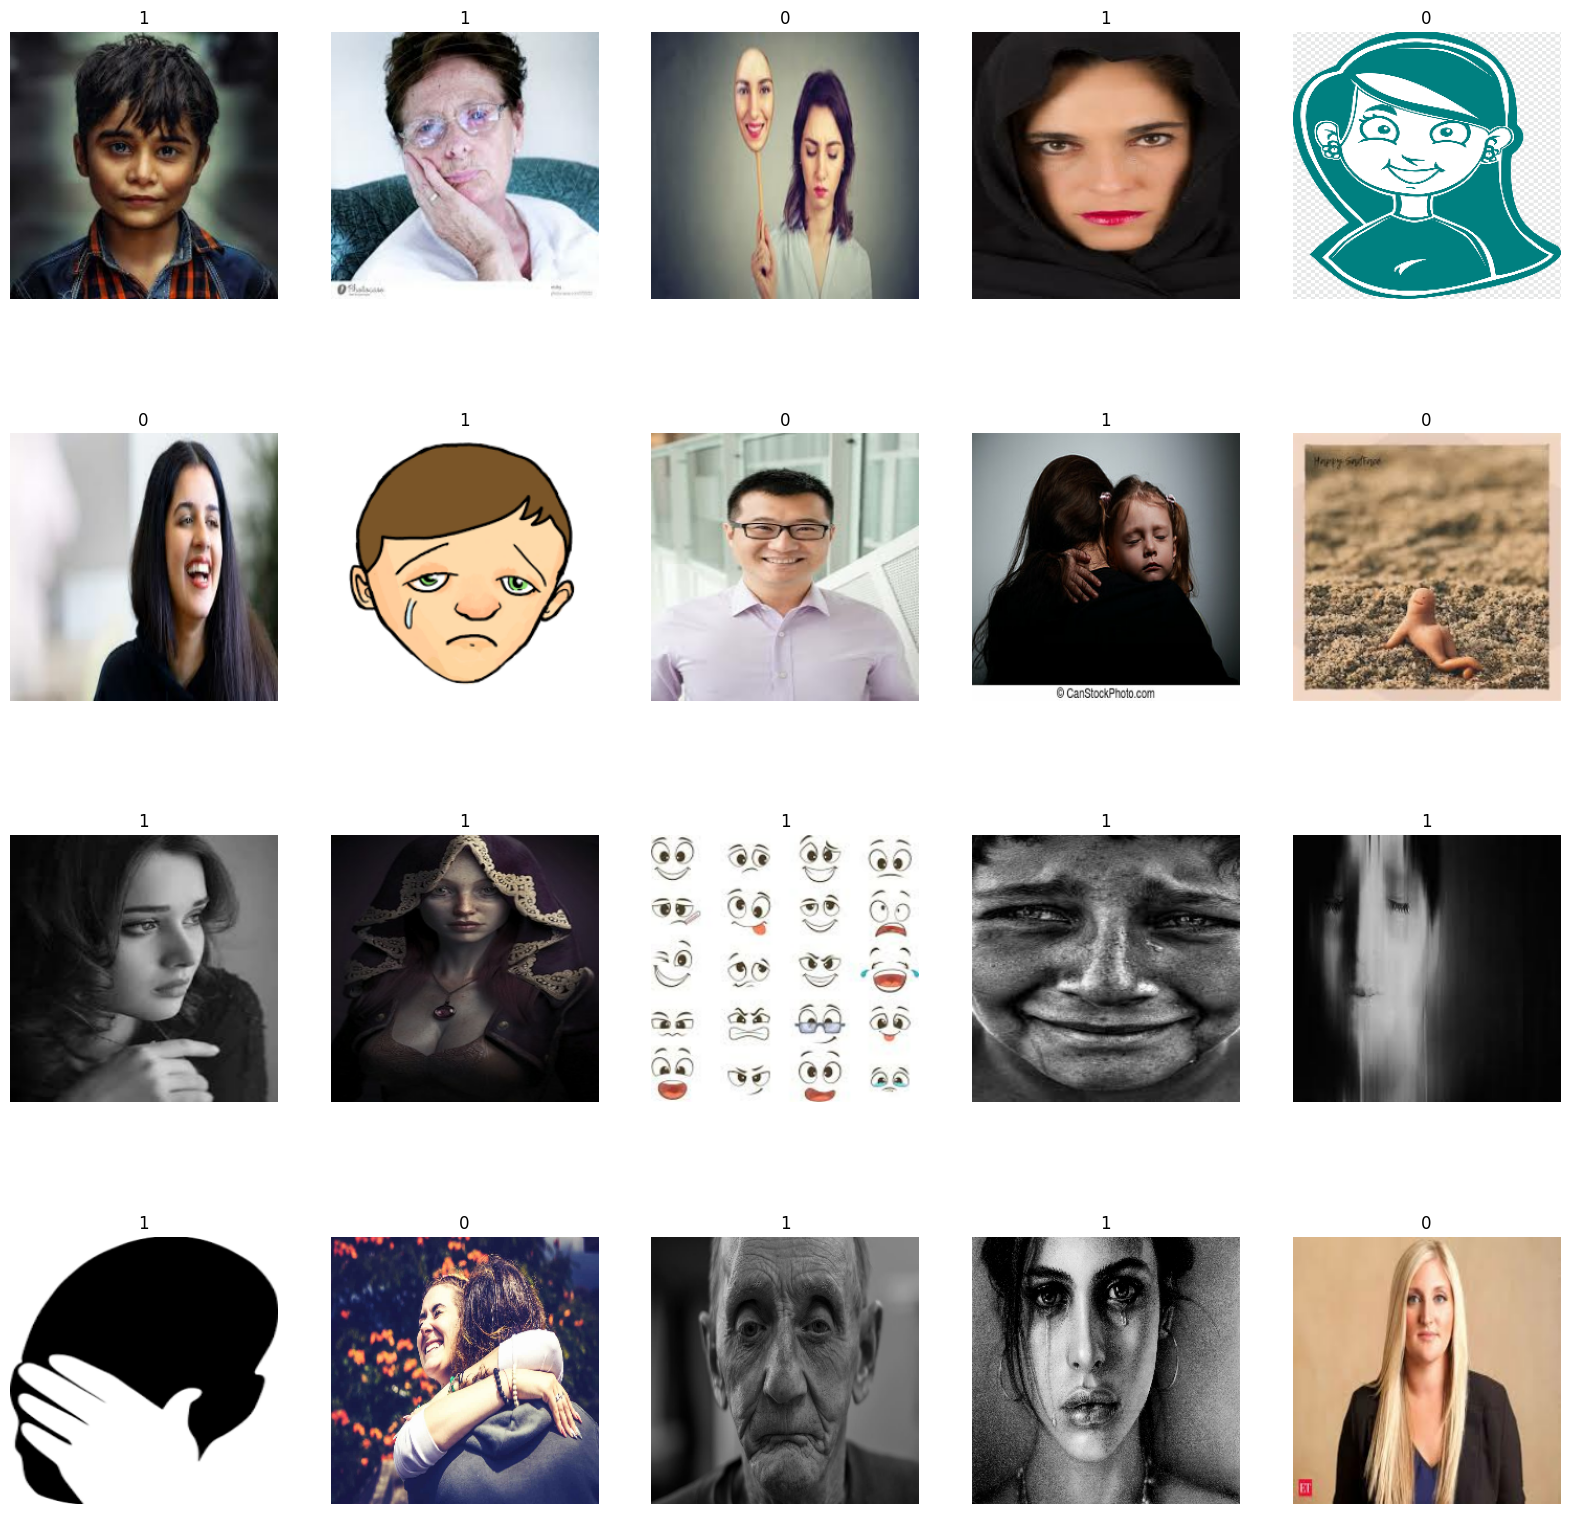

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:20]):
    ax[idx//5, idx%5].imshow(img.astype(int))
    ax[idx//5, idx%5].title.set_text(batch[1][idx])
    ax[idx//5, idx%5].axis('off')

<font color='#008080'><b>Applying Normalization to Image Data</b></font>

In [ ]:
data = data.map(lambda x,y: (x/255,y))

<font color='#008080'><b>Converting Data to Numpy Array</b></font>

In [ ]:
data.as_numpy_iterator().next()


(array([[[[1.        , 0.9529412 , 0.81960785],
          [0.98753065, 0.93912375, 0.8051164 ],
          [0.9308517 , 0.8763174 , 0.7392463 ],
          ...,
          [0.8686274 , 0.83128065, 0.72166055],
          [0.7705882 , 0.73170954, 0.6251532 ],
          [0.7490196 , 0.70980394, 0.6039216 ]],
 
         [[1.        , 0.9529412 , 0.81960785],
          [0.98753065, 0.93912375, 0.8051164 ],
          [0.9308517 , 0.8763174 , 0.7392463 ],
          ...,
          [0.8686274 , 0.83128065, 0.72166055],
          [0.7705882 , 0.73170954, 0.6251532 ],
          [0.7490196 , 0.70980394, 0.6039216 ]],
 
         [[1.        , 0.9529412 , 0.81960785],
          [0.98753065, 0.93912375, 0.8051164 ],
          [0.9308517 , 0.8763174 , 0.7392463 ],
          ...,
          [0.8686274 , 0.83128065, 0.72166055],
          [0.7705882 , 0.73170954, 0.6251532 ],
          [0.7490196 , 0.70980394, 0.6039216 ]],
 
         ...,
 
         [[1.        , 0.9372549 , 0.8509804 ],
          [0.98854

<font color='#008080'><b>Splitting the Data into Train, Validation, and Test Sets</b></font>

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

<font color='#008080'><b>Splitting the Data into Train, Validation, and Test Sets</b></font>

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D , Dense , Flatten , Dropout

<font color='#008080'><b>Creating a Sequential Model</b></font>

In [ ]:
model = Sequential()

<font color='#008080'><b>Building the Convolutional Neural Network (CNN) Architecture</b></font>

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

<font color='#008080'><b>Compiling the Model</b></font>

In [ ]:
model.compile('adam',loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

<font color='#008080'><b>Model Summary</b></font>

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

<font color='#008080'><b>Training the Model</b></font>

In [ ]:
hist = model.fit(train,epochs=30,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/30
44/44 [==============================] - 28s 381ms/step - loss: 0.7283 - accuracy: 0.5533 - val_loss: 0.6229 - val_accuracy: 0.6510
Epoch 2/30
44/44 [==============================] - 18s 383ms/step - loss: 0.6449 - accuracy: 0.6335 - val_loss: 0.6357 - val_accuracy: 0.6146
Epoch 3/30
44/44 [==============================] - 19s 393ms/step - loss: 0.6332 - accuracy: 0.6435 - val_loss: 0.6031 - val_accuracy: 0.6953
Epoch 4/30
44/44 [==============================] - 18s 388ms/step - loss: 0.6166 - accuracy: 0.6697 - val_loss: 0.6132 - val_accuracy: 0.6458
Epoch 5/30
44/44 [==============================] - 15s 320ms/step - loss: 0.6001 - accuracy: 0.6626 - val_loss: 0.6135 - val_accuracy: 0.6458
Epoch 6/30
44/44 [==============================] - 16s 331ms/step - loss: 0.5468 - accuracy: 0.7060 - val_loss: 0.5754 - val_accuracy: 0.6927
Epoch 7/30
44/44 [==============================] - 15s 333ms/step - loss: 0.4738 - accuracy: 0.7756 - val_loss: 0.6073 - val_accuracy: 0.6693

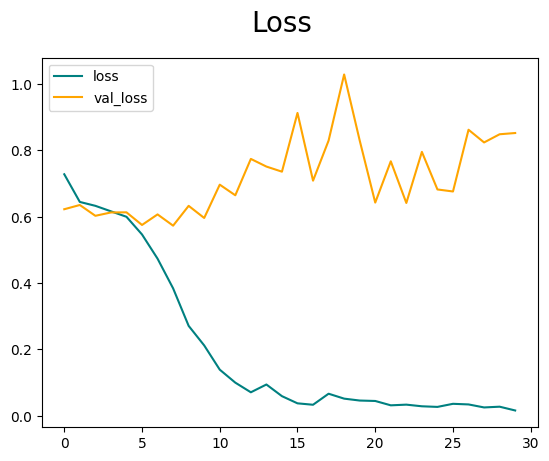

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<font color='#008080'><b>Plotting Accuracy</b></font>

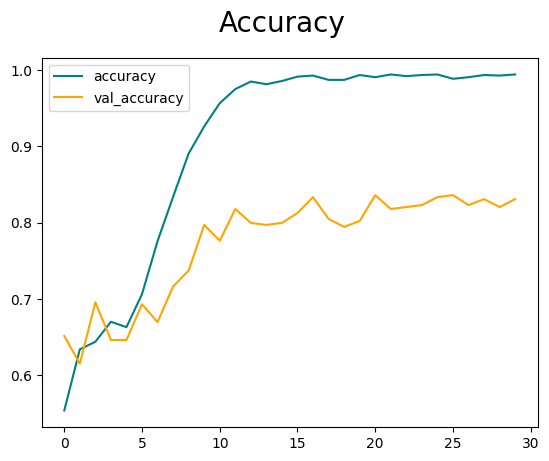

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'] , color ='teal' , label ='accuracy')
plt.plot(hist.history['val_accuracy'], color ='orange' , label = 'val_accuracy')
fig.suptitle('Accuracy' , fontsize =20)
plt.legend(loc="upper left")
plt.show()

<font color='#008080'><b>Importing Metrics</b></font>

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

<font color='#008080'><b>Initializing Metrics</b></font>

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

<font color='#008080'><b>Evaluating Metrics</b></font>

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 29ms/step


<font color='#008080'><b>Printing Metric Results</b></font>

In [ ]:
print(pre.result(), re.result(),acc.result())

tf.Tensor(0.85106385, shape=(), dtype=float32) tf.Tensor(0.78431374, shape=(), dtype=float32) tf.Tensor(0.8125, shape=(), dtype=float32)


<font color='#008080'><b>Displaying an Image</b></font>

<function matplotlib.pyplot.show(close=None, block=None)>

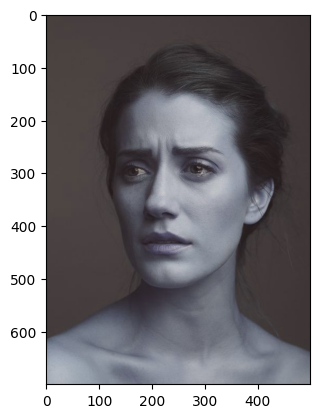

In [ ]:
img = cv2.imread('/kaggle/input/sad-and-happy-face-detection/666.jpg')
plt.imshow(img)
plt.show

<font color='#008080'><b>Resizing and Displaying an Image</b></font>

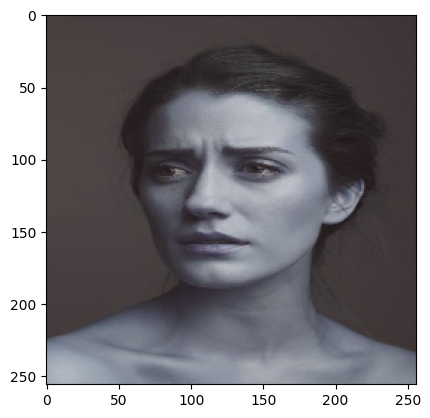

In [ ]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

<font color='#008080'><b>Performing Inference on Resized Image</b></font>



In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))


1/1 [==============================] - 0s 249ms/step


<font color='#008080'><b>Predicted Output</b></font>

In [ ]:
yhat

array([[0.9938095]], dtype=float32)

<font color='#008080'><b>Predicted Class</b></font>

In [ ]:
if yhat > 0.5:
    print (f'Predicted Class is Sad Face')
else:
    print (f'Predicted Class is Happy Face')

Predicted Class is Sad Face


<font color='#008080'><b>Loading a Saved Model</b></font>

In [ ]:
from tensorflow.keras.models import load_model

<font color='#008080'><b>Saving a Trained Model</b></font>

In [ ]:
model.save(os.path.join('imageclassifier.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<font color='#008080'><b>Loading a Saved Model</b></font>

In [ ]:
new_model = load_model('imageclassifier.h5')

<font color='#008080'><b>Using a Loaded Model for Predictions on New Images</b></font>

In [ ]:
new_model.predict(np.expand_dims(resize/255,0))


1/1 [==============================] - 0s 70ms/step


array([[0.9938095]], dtype=float32)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# تحميل النموذج المدرب
model = load_model('imageclassifier.h5')

# تهيئة الكاميرا
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("لا يمكن التقاط الصورة")
        break

    # تغيير حجم الصورة إلى الحجم المتوقع من النموذج
    resized_frame = cv2.resize(frame, (256, 256))
    # تغيير تنسيق الصورة إلى تنسيق RGB
    resized_frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    # تحويل الصورة إلى مصفوفة numpy
    image_array = np.array(resized_frame_rgb) / 255.0
    # توسيع الأبعاد لتناسب الشكل المتوقع للنموذج
    image_array_expanded = np.expand_dims(image_array, axis=0)

    # تحليل المشاعر باستخدام النموذج
    prediction = model.predict(image_array_expanded)

    # تحديد النص الذي سيتم عرضه على الإطار بناءً على النتيجة
    if prediction > 0.5:
        text = "Sad Face"
    else:
        text = "Happy Face"

    # عرض النتيجة على الإطار
    cv2.putText(frame, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # عرض الإطار
    cv2.imshow('Emotion Detection', frame)

    # انتظار الضغط على مفتاح 'q' لإنهاء البرنامج
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# إغلاق الكاميرا وإغلاق النافذة
cap.release()
cv2.destroyAllWindows()


لا يمكن التقاط الصورة


In [ ]:
from tensorflow.keras.models import load_model


model = load_model('imageclassifier.h5')

# حفظ النموذج كملف H5
model.save('converted_model.h5')



In [ ]:
# تنزيل الملف من Google Colab
from google.colab import files
files.download('converted_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>